In [7]:
import re
import pysam
import multiprocessing as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import *
import pyBigWig
from pyBioInfo.Range import GRange
from pyBioInfo.IO.File import BedFile
from pyBioInfo.Utils import ShiftLoader

# Make SV benchmark regions

In [2]:
def worker(f_bw, chrom, step, min_coverage, max_coverage):
    regions = []
    f = pyBigWig.open(f_bw)
    length = f.chroms()[chrom]
    step1 = step * 1000
    for start1 in range(0, length, step1):
        end1 = min(start1 + step1, length)
        covs = f.values(chrom, start1, end1)
        for start2 in range(start1, end1, step):
            end2 = min(start2 + step, end1)
            vs = np.nan_to_num(covs[start2 - start1:end2 - start1])
            mean = np.mean(vs)
            if mean < min_coverage or mean > max_coverage:
                if len(regions) == 0:
                    regions.append([chrom, start2, end2])
                else:
                    if start2 <= regions[-1][2]:
                        regions[-1][2] = end2
                    else:
                        regions.append([chrom, start2, end2])
    f.close()            
    return regions


def scan_extreme_coverage_regions(f_bw, f_bed, threads=1, min_coverage=15, max_coverage=80):
    array = []
    pool = mp.Pool(threads)
    f = pyBigWig.open(f_bw)
    for chrom in f.chroms():
        args = (f_bw, chrom, 100, min_coverage, max_coverage)
        array.append(pool.apply_async(worker, args))
    f.close()
    pool.close()
    pool.join()

    regions = []
    for r in array:
        regions.extend(r.get())
    regions.sort()
    
    with open(f_bed, "w+") as fw:
        for r in regions:
            fw.write("\t".join(map(str, r)) + "\n")

In [3]:
def collapse_regions(regions):
    regions = regions.copy()
    i = 0
    while i < len(regions) - 1:
        r1 = regions[i]
        r2 = regions[i + 1]
        if r1[0] == r2[0]:
            if r1[2] >= r2[1]:
                r1[2] = max(r1[2], r2[2])
                regions.pop(i + 1)
            else:
                i += 1
        else:
            i += 1
    return regions

def scan_dense_sv_regions(f_vcf, f_bed, slop=1000):
    svs = []
    with pysam.VariantFile(f_vcf) as f:
        for record in f:
            svtype = record.info["SVTYPE"]
            if svtype != "DEL" and svtype != "INS":
                continue
            if list(record.filter)[0] != "PASS":
                continue
            r = GRange(chrom=record.contig, start=record.start, end=record.stop, name=record.id)
            r.length = abs(record.info["SVLEN"])
            r.record = record
            svs.append(r)
    svs.sort()
    
    regions = []
    loader = ShiftLoader(svs)
    for sv in svs:
        chrom, start, end = sv.chrom, max(0, sv.start - slop), sv.end + slop
        hit = False
        for sv2 in loader.fetch(chrom=chrom, start=start, end=end):
            if sv2 is not sv:
                hit = True
        if hit:
            regions.append([chrom, start, end])
    regions.sort()
    
    regions = collapse_regions(regions)
    
    with open(f_bed, "w+") as fw:
        for r in regions:
            fw.write("\t".join(map(str, r)) + "\n")

In [4]:
def scan_long_sv_regions(f_vcf, f_bed, max_length=10000, slop=1000):
    regions = []
    
    with pysam.VariantFile(f_vcf) as f:
        for record in f:
            svtype = record.info["SVTYPE"]
            if svtype != "DEL" and svtype != "INS":
                continue
            if list(record.filter)[0] != "PASS":
                continue
            if abs(record.info["SVLEN"]) > max_length:
                chrom = record.contig
                start = record.start
                end = record.stop
                start = max(0, start - slop)
                end = end + slop
                
                regions.append([chrom, start, end])
    regions.sort()
    
    regions = collapse_regions(regions)

    with open(f_bed, "w+") as fw:
        for r in regions:
            fw.write("\t".join(map(str, r)) + "\n")

## 1. For HG001

## 2. For C57/DBA

In [8]:
f_bw = "../../7_DBA_ONT_bulk/results/tracks/Bulk_WGS_ONT_DBA.bw"
f_bed = "results/DBA_WGS_ONT.coverage_lt_10_gt_80.bed"
scan_extreme_coverage_regions(f_bw, f_bed, 24, 10, 80)

In [9]:
f_bw = "../../7_DBA_ONT_bulk/results/tracks/Bulk_WGS_ONT_DBA.bw"
f_bed = "results/DBA_WGS_ONT.coverage_lt_15_gt_80.bed"
scan_extreme_coverage_regions(f_bw, f_bed, 24, 15, 80)

In [12]:
f_vcf = "../../7_DBA_ONT_bulk/results/sv/cutesv/Bulk_WGS_ONT_DBA.vcf.gz"
f_bed = "results/DBA_WGS_ONT.dense_sv_1kb.bed"
scan_dense_sv_regions(f_vcf, f_bed, 1000)

In [13]:
f_vcf = "../../7_DBA_ONT_bulk/results/sv/cutesv/Bulk_WGS_ONT_DBA.vcf.gz"
f_bed = "results/DBA_WGS_ONT.long_sv_10kb_slop_1kb.bed"
scan_long_sv_regions(f_vcf, f_bed, max_length=10000, slop=1000)

In [14]:
regions = []

with open("results/DBA_WGS_ONT.coverage_lt_10_gt_80.bed") as f:
    for line in f:
        chrom, start, end = line.strip("\n").split("\t")
        start, end = int(start), int(end)
        start, end = max(0, start - 1000), end + 1000
        regions.append([chrom, start, end])
        
with open("results/DBA_WGS_ONT.dense_sv_1kb.bed") as f:
    for line in f:
        chrom, start, end = line.strip("\n").split("\t")
        start, end = int(start), int(end)
        regions.append([chrom, start, end])
        
with open("results/DBA_WGS_ONT.long_sv_10kb_slop_1kb.bed") as f:
    for line in f:
        chrom, start, end = line.strip("\n").split("\t")
        start, end = int(start), int(end)
        regions.append([chrom, start, end])
    
regions.sort()
print("All regions:", len(regions))

regions = collapse_regions(regions)
print("Collapsed regions:", len(regions))

regions.sort()

All regions: 24382
Collapsed regions: 15733


In [15]:
with open("results/DBA_WGS_ONT.benchmark_blacklist.bed", "w+") as fw:
    for r in regions:
        fw.write("\t".join(map(str, r)) + "\n")

# Benchmark SV

In [16]:
f_blacklist = "../../4_NanoStrandSeq_Phasing/results/Mouse_Cell_200/blackhole/blacklist.bed.gz"
with BedFile(f_blacklist) as f:
    blacklist = [x for x in f]
print(len(blacklist))

3235


In [17]:
f_blacklist = "results/DBA_WGS_ONT.benchmark_blacklist.bed"
with BedFile(f_blacklist) as f:
    blacklist = [x for x in f]
print(len(blacklist))

15733


In [20]:
def load_svs(path):
    dat = pd.read_csv(path, sep="\t")
    dat = dat[[re.match("^chr([0-9]+|[X])$", chrom) is not None for chrom in dat["Chrom"]]]
    dat = dat[dat["AgreeRead"] >= 3]
    dat = dat[dat["AgreeRead"] > (dat["DisagreeRead"] * 0.25)]
    
    svs = []
    for chrom, start, end, name, length in dat[["Chrom", "Start", "End", "Name", "Length"]].values:
        obj = GRange(chrom=chrom, start=start, end=end, name=name)
        obj.svlen = length
        svs.append(obj)
    svs.sort()
    loader = ShiftLoader(blacklist)
    svs1 = []
    for sv in svs:
        n = len(list(loader.fetch(obj=sv)))
        if n == 0:
            svs1.append(sv)

    flags = [True] * len(svs1)
    loader = ShiftLoader(svs1)
    for i, sv in enumerate(svs1):
        n = len(list(loader.fetch(chrom=sv.chrom, start=sv.start - 500, end=sv.end + 500)))
        if n > 1:
            flags[i] = False
    svs2 = []
    for flag, sv in zip(flags, svs1):
        if flag:
            svs2.append(sv)
    return svs2

def overlap_sv(svs1, svs2):
    n = 0
    loader = ShiftLoader(svs2)
    for sv in svs1:
        hit = False
        for sv2 in loader.fetch(chrom=sv.chrom, start=sv.start - 1000, end=sv.end + 1000):
            vmin = min(sv.svlen, sv2.svlen)
            vmax = max(sv.svlen, sv2.svlen)
            if vmin > vmax * 0.7:
                hit = True
        if hit:
            n += 1
    return n

del_ins_svs1 = load_svs("../../7_DBA_ONT_bulk/results/sv/quantify/Bulk_WGS_ONT_DBA_lite.tsv")
del_ins_svs2 = load_svs("../../4_NanoStrandSeq_Phasing/results/Mouse_Cell_200/sv/quantify_merged_lite.tsv")

Recall: 0.676871561827314
Precision: 0.9206400867914294
Recall: 0.6432081629590727
Precision: 0.8884051210283522


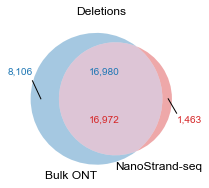

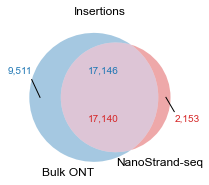

In [54]:
s1 = "DBA_ONT_bulk"
s2 = "NanoStrand-seq"
for t in ["DEL", "INS"]:
    svs1 = list(filter(lambda sv: t in sv.name, del_ins_svs1))
    svs2 = list(filter(lambda sv: t in sv.name, del_ins_svs2))
    n1 = len(svs1)
    n2 = overlap_sv(svs1, svs2)
    n3 = len(svs2)
    n4 = overlap_sv(svs2, svs1)
    print("Recall:", n2 / n1)
    print("Precision:", n4 / n3)

    plt.figure(figsize=(3, 3))
    if t == "DEL":
        plt.title("Deletions")
    else:
        plt.title("Insertions")
    vs = [n1 - n2, n3 - n4, int((n2 + n4)/2)]
    ret = venn2(vs, set_labels=["Bulk ONT", "NanoStrand-seq"], set_colors=["C0", "C3"])
    if False:
        ret.subset_labels[0].set_text(format(vs[0], ","))
        ret.subset_labels[1].set_text(format(vs[1], ","))
        ret.subset_labels[2].set_text("%s   \n\n   %s" % (format(n2, ","), format(n4, ",")))
        plt.plot([0.25, 0.4], [-0.05, 0], color="black", lw=1)
        plt.plot([-0.35, -0.2], [0, 0.05], color="black", lw=1)
    else:
        ret.subset_labels[0].set_text(None)
        ret.subset_labels[1].set_text(None)
        ret.subset_labels[2].set_text(None)
        plt.text(-0.6, 0.2, "%s" % format(n1 - n2, ","), ha="right", color="C0")
        plt.text(0, 0.2, "%s" % format(n2, ","), ha="center", color="C0")
        plt.text(0.6, -0.2, "%s" % format(n3 - n4, ","), ha="left", color="C3")
        plt.text(0, -0.2, "%s" % format(n4, ","), ha="center", color="C3")
        plt.plot([-0.6, -0.53], [0.15, 0], color="black", lw=1) 
        plt.plot([0.6, 0.53], [-0.12, 0], color="black", lw=1)
    
    plt.tight_layout()
    plt.savefig("figures/benchmark_sv_%s_%s_%s.pdf" % (s1, s2, t), dpi=300)

Recall: 0.6744250815628232
Precision: 0.9213660340420904
Recall: 0.6432255392839664
Precision: 0.8869276295296439


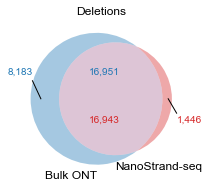

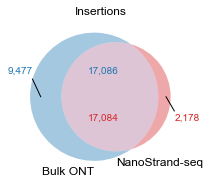

In [21]:
s1 = "DBA_ONT_bulk"
s2 = "NanoStrand-seq"
for t in ["DEL", "INS"]:
    svs1 = list(filter(lambda sv: t in sv.name, del_ins_svs1))
    svs2 = list(filter(lambda sv: t in sv.name, del_ins_svs2))
    n1 = len(svs1)
    n2 = overlap_sv(svs1, svs2)
    n3 = len(svs2)
    n4 = overlap_sv(svs2, svs1)
    print("Recall:", n2 / n1)
    print("Precision:", n4 / n3)

    plt.figure(figsize=(3, 3))
    if t == "DEL":
        plt.title("Deletions")
    else:
        plt.title("Insertions")
    vs = [n1 - n2, n3 - n4, int((n2 + n4)/2)]
    ret = venn2(vs, set_labels=["Bulk ONT", "NanoStrand-seq"], set_colors=["C0", "C3"])
    if False:
        ret.subset_labels[0].set_text(format(vs[0], ","))
        ret.subset_labels[1].set_text(format(vs[1], ","))
        ret.subset_labels[2].set_text("%s   \n\n   %s" % (format(n2, ","), format(n4, ",")))
        plt.plot([0.25, 0.4], [-0.05, 0], color="black", lw=1)
        plt.plot([-0.35, -0.2], [0, 0.05], color="black", lw=1)
    else:
        ret.subset_labels[0].set_text(None)
        ret.subset_labels[1].set_text(None)
        ret.subset_labels[2].set_text(None)
        plt.text(-0.6, 0.2, "%s" % format(n1 - n2, ","), ha="right", color="C0")
        plt.text(0, 0.2, "%s" % format(n2, ","), ha="center", color="C0")
        plt.text(0.6, -0.2, "%s" % format(n3 - n4, ","), ha="left", color="C3")
        plt.text(0, -0.2, "%s" % format(n4, ","), ha="center", color="C3")
        plt.plot([-0.6, -0.53], [0.15, 0], color="black", lw=1) 
        plt.plot([0.6, 0.53], [-0.12, 0], color="black", lw=1)
    
    plt.tight_layout()
    plt.savefig("figures/benchmark_sv_%s_%s_%s.pdf" % (s1, s2, t), dpi=300)

# 20240205

In [64]:
import sys
import json
import pandas as pd
from collections import Counter, defaultdict
import pysam
from pyBioInfo.Range import GRange
from pyBioInfo.Utils import ShiftLoader


def load_svs(path):
    svs = []
    with pysam.VariantFile(path) as f:
        for record in f:
            if record.contig == "chrY":
                continue
            svtype = record.info["SVTYPE"]
            if svtype != "DEL" and svtype != "INS":
                continue
#             if list(record.filter)[0] != "PASS":
#                 continue
            svlen = abs(record.info["SVLEN"])
            sv = GRange(chrom=record.contig, start=record.start, end=record.stop, name=record.id)
            sv.record = record
            sv.svtype = svtype
            sv.svlen = svlen
            svs.append(sv)
    return svs


def filter_sv_by_regions(svs, regions):
    svs1 = []
    loader = ShiftLoader(regions)
    for sv in svs:
        n = len(list(loader.fetch(obj=sv)))
        if n == 0:
            svs1.append(sv)
    return svs1


def get_recall(svs_ref, svs_que, svtype):
    
    svs_ref = list(filter(lambda sv: sv.svtype == svtype, svs_ref))
    svs_que = list(filter(lambda sv: sv.svtype == svtype, svs_que))
    
    print("-" * 80)
    print(svtype, len(svs_ref), len(svs_que), sep="\t")
    print(Counter([sv.gt for sv in svs_ref]))

    
    n_hit = 0
    loader = ShiftLoader(svs_que)
    counter = defaultdict(int)
    for sv in svs_ref:
        hit = False
        for sv2 in loader.fetch(chrom=sv.chrom, start=sv.start - 1000, end=sv.end + 1000):
            if sv.svtype == sv2.svtype and min(sv.svlen, sv2.svlen) >= max(sv.svlen, sv2.svlen) * 0.7:
                try:
                    sv.new_gt = sv2.nss_gt
                except AttributeError:
                    pass
                hit = True
                break
        if hit:
            counter[sv.gt] += 1
            n_hit += 1
    print(counter)
    data = dict()
    data["Reference"] = len(svs_ref)
    data["Query"] = len(svs_que)
    data["Reference_Hit"] = n_hit
    data["Reference_Recall"] = data["Reference_Hit"] / data["Reference"]
    
    return data

In [48]:
f_vcf1 = "../../3_NanoStrandSeq_PseudoBulk/results/sv/filtered/PacBio.full.vcf.gz"
f_vcf2 = "../../3_NanoStrandSeq_PseudoBulk/results/sv/filtered/NSS.full.vcf.gz"
f_quant1 = "../../3_NanoStrandSeq_PseudoBulk/results/sv/quantify_lite/PacBio.full.tsv"
f_quant2 = "../../3_NanoStrandSeq_PseudoBulk/results/sv/quantify_lite/NSS.full.tsv"
f_bed = "../02_pseudobulk/data/benchmark_sv_blacklist.bed"
min_query_cell = 3

if True:
    f_vcf2 = "../../4_NanoStrandSeq_Phasing/results/HG001_Cell_350/sv/cutesv.filtered.vcf.gz"
    f_quant2 = "../../4_NanoStrandSeq_Phasing/results/HG001_Cell_350/sv/quantify_merged.tsv"

    
# load SVs

svs_ref = load_svs(f_vcf1)
svs_que = load_svs(f_vcf2)

# SV names

max_length = 10000
min_length = 50
min_reads = 5
min_freq = 0.2

dat = pd.read_csv(f_quant1, sep="\t")
dat["AgreeReadRatio"] = dat["AgreeRead"] / (dat["AgreeRead"] + dat["DisagreeRead"])
dat = dat[dat["Length"] <= max_length]
dat = dat[dat["Length"] >= min_length]
dat = dat[dat["Chrom"] != "chrY"]
dat = dat[dat["AgreeRead"] >= min_reads]
dat = dat[(dat["AgreeRead"] / (dat["AgreeRead"] + dat["DisagreeRead"])) >= min_freq]
ratios_ref = {name: ratio for name, ratio in dat[["Name", "AgreeReadRatio"]].values}
dat_ref = dat
names_ref = set(dat["Name"])

dat = pd.read_csv(f_quant2, sep="\t")
dat["AgreeReadRatio"] = dat["AgreeRead"] / (dat["AgreeRead"] + dat["DisagreeRead"])
dat = dat[dat["Length"] <= max_length]
dat = dat[dat["Length"] >= min_length]
dat = dat[dat["Chrom"] != "chrY"]
dat = dat[dat["AgreeRead"] >= min_reads]
if min_query_cell > 1:
    dat = dat[dat["AgreeCell"] >= min_query_cell]
dat = dat[(dat["AgreeRead"] / (dat["AgreeRead"] + dat["DisagreeRead"])) >= min_freq]
ratios_que = {name: ratio for name, ratio in dat[["Name", "AgreeReadRatio"]].values}
dat_que = dat
names_que = set(dat["Name"])

# filter sv by names

svs_ref_1 = list(filter(lambda sv: sv.name in names_ref, svs_ref))
svs_que_1 = list(filter(lambda sv: sv.name in names_que, svs_que))

# blacklist regions

regions = []
with open(f_bed) as f:
    for line in f:
        chrom, start, end = line.strip("\n").split("\t")
        start, end = int(start), int(end)
        regions.append(GRange(chrom=chrom, start=start, end=end))
regions.sort()

# filter sv by regions

svs_ref_2 = filter_sv_by_regions(svs_ref_1, regions)
svs_que_2 = filter_sv_by_regions(svs_que_1, regions)

# benchmark

ref = svs_ref_2
que = svs_que_2

for sv in ref:
    if ratios_ref[sv.name] >= 0.8:
        sv.gt = "1/1"
    else:
        sv.gt = "0/1"
    
for sv in que:
    if ratios_que[sv.name] >= 0.8:
        sv.gt = "1/1"
    else:
        sv.gt = "0/1"

In [61]:
m = pd.read_csv("../../0_PlotFigures/05_phasing_sv/results/quant_phased_svs.HG001_Cell_350.tsv", sep="\t", header=0)
nss_gt = dict()
for name, gt in m[["Name_HP1", "GenoType"]].values:
    if gt != ".":
        nss_gt[name] = gt
for sv in que:
    if sv.name in nss_gt:
        sv.nss_gt = nss_gt[sv.name]

In [66]:
data = dict()

# deletion

d1 = get_recall(ref, que, "DEL")
d2 = get_recall(que, ref, "DEL")
recall = d1["Reference_Recall"]
precision = d2["Reference_Recall"]
f1 = 2 * recall * precision / (recall + precision)
data["Del_Recall"] = recall
data["Del_Precision"] = precision
data["Del_F1"] = f1
data["Del_Detail"] = [d1, d2]

# precision

d1 = get_recall(ref, que, "INS")
d2 = get_recall(que, ref, "INS")
recall = d1["Reference_Recall"]
precision = d2["Reference_Recall"]
f1 = 2 * recall * precision / (recall + precision)
data["Ins_Recall"] = recall
data["Ins_Precision"] = precision
data["Ins_F1"] = f1
data["Ins_Detail"] = [d1, d2]

# output
# with open(outfile, "w+") as fw:
#     json.dump(data, fw, indent=4)
data

--------------------------------------------------------------------------------
DEL	3160	3531
Counter({'0/1': 1846, '1/1': 1314})
defaultdict(<class 'int'>, {'1/1': 1296, '0/1': 1611})
--------------------------------------------------------------------------------
DEL	3531	3160
Counter({'0/1': 2154, '1/1': 1377})
defaultdict(<class 'int'>, {'1/1': 1251, '0/1': 1701})
--------------------------------------------------------------------------------
INS	5134	5112
Counter({'0/1': 2712, '1/1': 2422})
defaultdict(<class 'int'>, {'0/1': 2326, '1/1': 2094})
--------------------------------------------------------------------------------
INS	5112	5134
Counter({'0/1': 3112, '1/1': 2000})
defaultdict(<class 'int'>, {'0/1': 2601, '1/1': 1847})


{'Del_Recall': 0.9199367088607595,
 'Del_Precision': 0.8360237892948174,
 'Del_F1': 0.8759752557771202,
 'Del_Detail': [{'Reference': 3160,
   'Query': 3531,
   'Reference_Hit': 2907,
   'Reference_Recall': 0.9199367088607595},
  {'Reference': 3531,
   'Query': 3160,
   'Reference_Hit': 2952,
   'Reference_Recall': 0.8360237892948174}],
 'Ins_Recall': 0.8609271523178808,
 'Ins_Precision': 0.8701095461658842,
 'Ins_F1': 0.8654939949468944,
 'Ins_Detail': [{'Reference': 5134,
   'Query': 5112,
   'Reference_Hit': 4420,
   'Reference_Recall': 0.8609271523178808},
  {'Reference': 5112,
   'Query': 5134,
   'Reference_Hit': 4448,
   'Reference_Recall': 0.8701095461658842}]}

In [69]:
counter = defaultdict(int)
for sv in svs_ref:
    try:
        counter[sv.new_gt] += 1
    except AttributeError:
        pass
counter

defaultdict(int, {'1|0': 1623, '1|1': 2367, '0|1': 1577})